# Análisis de Retención de Usuarios

Esta notebook implementa un análisis exhaustivo de la retención de usuarios en la plataforma Peliplat, utilizando los datos limpios procesados previamente. El objetivo es cuantificar la capacidad de la plataforma para mantener a los usuarios activos a lo largo del tiempo.

**Conceptos clave:**
- **Retención**: Porcentaje de usuarios que continúan activos después de un período específico desde su registro
- **Cohorte**: Grupo de usuarios que se registraron en un mismo período
- **Segmentación**: Análisis de retención por país, campaña u otras variables demográficas

## 1. Configuración del Entorno de Análisis

En esta primera sección se realizan las importaciones de librerías necesarias y se configura el entorno de trabajo:

1. Librerías estándar para análisis de datos:
   - `pandas` y `numpy` para manipulación y procesamiento de datos
   - `seaborn` y `matplotlib` para visualizaciones estadísticas

2. Configuración de rutas del proyecto:
   - Se ajusta el `sys.path` para poder importar módulos propios desde cualquier ubicación
   - Se implementa una estructura robusta independiente de la ubicación de ejecución

3. Importación de funciones propias:
   - Módulo `retention.py` con funciones especializadas para cálculo de métricas de retención
   - Utilidades de visualización desde `utils_peliplat` que incluyen:
     - Configuración de estilo corporativo
     - Funciones para tablas y gráficos
     - Paleta de colores corporativa

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

# Configurar path del proyecto
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_dir = os.path.dirname(current_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

# Importar nuestras funciones
from src.analysis.retention import (
    calcular_retencion_periodo,
    calcular_retencion_por_grupo,
    calcular_retencion_por_pais,
    calcular_retencion_pais_serie
)
from utils.utils_peliplat import (
    configurar_estilo_peliplat,
    mostrar_tabla,
    guardar_figura,
    COLORES_PELIPLAT
)

## 2. Carga de Datos y Configuración Visual

En esta sección se realizan dos operaciones fundamentales:

1. Carga del dataset de usuarios:
   - Se utiliza el archivo CSV procesado en la etapa de limpieza (`peliplat_users_clean.csv`)
   - Se especifica la conversión automática de columnas temporales mediante `parse_dates`
   - Las fechas `signup_date` y `last_active` se cargan directamente como objetos datetime

2. Configuración del estilo visual:
   - Se aplica la función `configurar_estilo_peliplat()` que establece:
     - Paleta de colores corporativa
     - Formato y tamaño de gráficos
     - Estilos de texto y etiquetas
     - Grillas y elementos visuales consistentes

Esta configuración dual prepara tanto los datos como el entorno visual para el análisis subsiguiente, garantizando consistencia y calidad en los resultados.

In [29]:
# Cargar datos de usuarios
users = pd.read_csv('../data/processed/peliplat_users_clean.csv', 
                    parse_dates=['signup_date', 'last_active'])

# Configurar estilo para visualizaciones
configurar_estilo_peliplat()

## 3. Cálculo de Retención Global

En esta sección se calcula la métrica fundamental de retención global para toda la plataforma:

1. Preparación de datos temporales:
   - Se calcula la columna `days_active` como la diferencia en días entre la última actividad y el registro
   - Esta métrica representa el tiempo de vida del usuario en la plataforma

2. Cálculo de la retención a 30 días:
   - Se utiliza la función `calcular_retencion_periodo` que implementa la metodología estándar
   - Se especifican los parámetros:
     - Dataframe de usuarios
     - Columnas de fechas relevantes
     - Período de análisis (30 días)
   - La métrica resultante representa el porcentaje de usuarios que permanecen activos 30 días después de su registro

3. Visualización de resultados:
   - Se construye una tabla con la función `mostrar_tabla` que:
     - Presenta el total de usuarios analizados
     - Muestra el porcentaje de retención a 30 días con formato adecuado
     - Guarda automáticamente la visualización en el directorio de figuras

In [30]:
# Calcular días activos para cada usuario
users['days_active'] = (users['last_active'] - users['signup_date']).dt.days

# Calcular la tasa de retención global a 30 días
retencion_global = calcular_retencion_periodo(
    df=users,
    fecha_registro='signup_date',
    fecha_ultima_actividad='last_active',
    dias_activos='days_active',
    dias_periodo=30
)

# Mostrar resultados de retención global
mostrar_tabla(
    pd.DataFrame({
        'Métrica': ['Usuarios totales', 'Retención a 30 días'],
        'Valor': [len(users), f"{retencion_global:.2f}%"]
    }),
    titulo="Retención Global",
    guardar=True,
    nombre_archivo="retencion_global"
)


Retención Global


,Métrica,Valor
0,Usuarios totales,200
1,Retención a 30 días,72.94%


Tabla guardada en HTML: ../reports/tables\retencion_global.html
Tabla guardada en PNG: ../reports/tables\retencion_global.png


## 4. Análisis de Retención Multi-período

Esta sección amplía el análisis anterior calculando la retención para múltiples horizontes temporales, permitiendo comprender la evolución de la permanencia de usuarios:

1. Definición de períodos de análisis:
   - Se establece `max_dias = 89` como el período máximo cubierto por los datos
   - Se configura un conjunto de períodos estándar: 7, 14, 30, 60 y 89 días
   - Esta selección permite analizar desde la retención a corto plazo (semanal) hasta la retención a largo plazo (trimestral)

2. Cálculo iterativo de retención:
   - Para cada período se aplica la misma metodología consistente
   - Se mantienen constantes los parámetros de fechas y métrica de actividad
   - Los resultados se almacenan secuencialmente para su posterior análisis

3. Estructuración y visualización de resultados:
   - Se construye un DataFrame con dos columnas: período y porcentaje de retención
   - Se aplica formato adecuado para períodos (N días) y retención (porcentaje con 2 decimales)
   - Se visualiza mediante una tabla estructurada que se guarda automáticamente

Este análisis multi-período revela la curva de decaimiento en la retención, información crítica para entender el ciclo de vida de los usuarios en la plataforma.

In [31]:
max_dias = 89 # Maximo periodo de dias que cubren los datos

# Calcular retención para diferentes períodos
periodos = [7, 14, 30, 60, max_dias]
retenciones = []

for dias in periodos:
    retencion = calcular_retencion_periodo(
        df=users,
        fecha_registro='signup_date',
        fecha_ultima_actividad='last_active',
        dias_activos='days_active',
        dias_periodo=dias
    )
    retenciones.append(retencion)

# Crear DataFrame con resultados
df_retenciones = pd.DataFrame({
    'Período': [f'{dias} días' for dias in periodos],
    'Retención (%)': [f"{ret:.2f}%" for ret in retenciones]
})

# Mostrar y guardar resultados
mostrar_tabla(
    df_retenciones,
    titulo="Retención por período",
    guardar=True,
    nombre_archivo="retencion_por_periodo"
)


Retención por período


,Período,Retención (%)
0,7 días,93.00%
1,14 días,85.00%
2,30 días,72.94%
3,60 días,37.65%
4,89 días,14.29%


Tabla guardada en HTML: ../reports/tables\retencion_por_periodo.html
Tabla guardada en PNG: ../reports/tables\retencion_por_periodo.png


## 4. Análisis de Retención Multi-período

### 4.1 Visualización de Retención Acumulada

En esta sección se implementa una visualización detallada de la retención acumulada a lo largo del tiempo. El proceso incluye:

1. Preparación de datos temporales:
   - Generación de serie temporal completa de 0 a 89 días
   - Cálculo de retención diaria mediante `calcular_retencion_periodo`
   - Conversión de resultados a formato proporcional para visualización

2. Generación de gráfico base:
   - Configuración de figura con dimensiones 12x7
   - Implementación de línea principal con marcadores
   - Aplicación de color corporativo `COLORES_PELIPLAT['turquesa']`
   - Incorporación de cuadrícula de referencia

3. Incorporación de anotaciones:
   - Marcado de hitos temporales clave (7, 14, 30, 60, 89 días)
   - Implementación de sistema de flechas con colores diferenciados
   - Ajuste de posiciones para evitar superposición de etiquetas
   - Inclusión de valores porcentuales precisos

4. Formato y exportación:
   - Configuración de títulos y etiquetas
   - Ajuste de escalas y márgenes
   - Exportación automática mediante `guardar_figura`
   - Presentación final con `plt.show()`

Figura guardada en: ../reports/figures\curva_retencion_general_acumulada.png


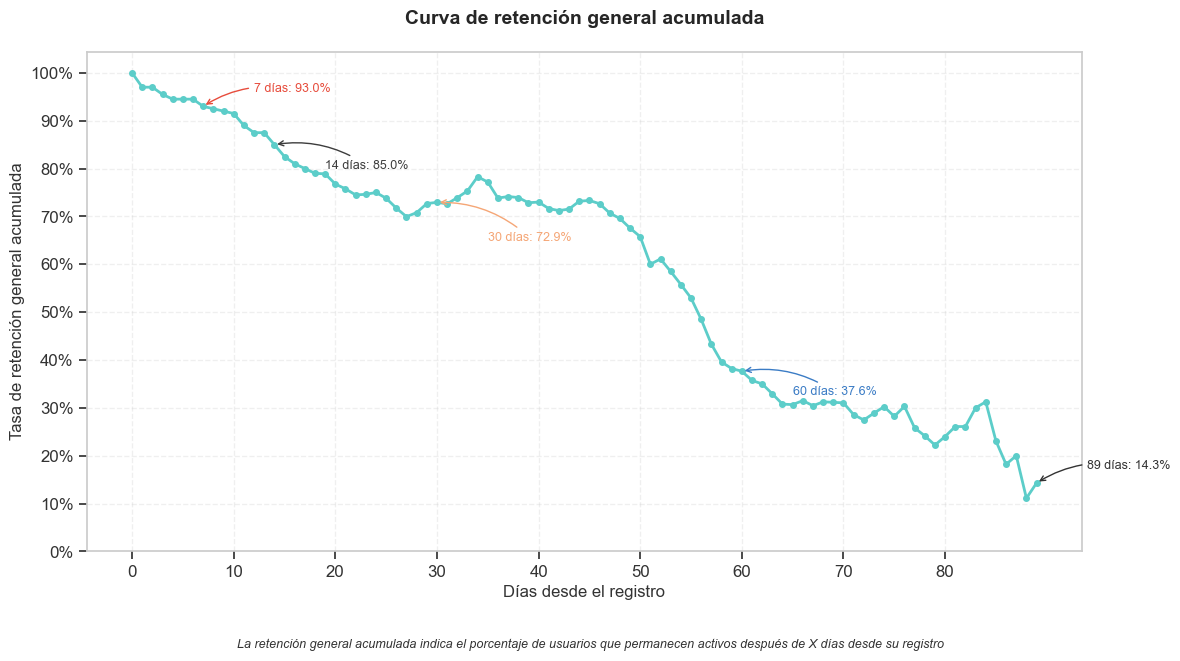

In [32]:
dias = list(range(0, max_dias + 1))
retencion_acumulada = [
    calcular_retencion_periodo(
        df=users,
        fecha_registro='signup_date',
        fecha_ultima_actividad='last_active',
        dias_activos='days_active',
        dias_periodo=d
    ) / 100  # Convertir a proporción para el gráfico
    for d in dias
]
# Crear el gráfico
fig = plt.figure(figsize=(12, 7))
plt.plot(dias, retencion_acumulada, marker='o', markersize=4, linestyle='-', 
         color=COLORES_PELIPLAT['turquesa'], linewidth=2)

# Días a marcar
hitos = [7, 14, 30, 60, max_dias]
colores = [COLORES_PELIPLAT['accent'], COLORES_PELIPLAT['gris_oscuro'], 
           COLORES_PELIPLAT['secundario'], COLORES_PELIPLAT['azul'],
           COLORES_PELIPLAT['principal']]

# Ajustar posiciones_y para evitar superposición
posiciones_y = [0.03, -0.05, -0.08, -0.05, 0.03]  # Cambié el valor para el día 30 a -0.08

# Añadir anotaciones para todos los hitos
for dia, color, pos_y in zip(hitos, colores, posiciones_y):
    plt.annotate(f'{dia} días: {retencion_acumulada[dia]:.1%}', 
                xy=(dia, retencion_acumulada[dia]), xycoords='data',
                xytext=(dia + 5, retencion_acumulada[dia] + pos_y), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color=color),
                fontsize=9, color=color)

# Configurar etiquetas y título
plt.xlabel("Días desde el registro", fontsize=12)
plt.ylabel("Tasa de retención general acumulada", fontsize=12)
plt.title("Curva de retención general acumulada", fontsize=14, fontweight='bold', pad=20)

# Añadir subtítulo explicativo
plt.figtext(0.5, 0.01, "La retención general acumulada indica el porcentaje de usuarios que permanecen activos después de X días desde su registro", 
          ha='center', fontsize=9, style='italic', color=COLORES_PELIPLAT['texto'])

# Configurar cuadrícula con estilo Peliplat
plt.grid(True, alpha=0.3, linestyle='--')

# Mejorar aspecto
plt.xticks(range(0, max_dias + 1, 10))
plt.yticks([x/10 for x in range(0, 11, 1)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# Ajustar márgenes
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Guardar la figura
guardar_figura(fig, nombre_archivo="curva_retencion_general_acumulada.png")

plt.show()

## 5. Análisis de Retención por País

En esta sección se analiza la retención segmentada por país para identificar diferencias geográficas en el comportamiento de los usuarios. Se implementa:

1. Cálculo de retención por país:
   - Se utiliza la función `calcular_retencion_por_pais`
   - Se mantienen los parámetros de fechas consistentes con análisis previos
   - Se enfoca en el período estándar de 30 días para comparabilidad

2. Visualización de resultados:
   - Se transpone la matriz para presentar países como filas
   - Se implementa `mostrar_tabla` con formato porcentual
   - Se guarda automáticamente la visualización para referencia futura

Este análisis permite identificar mercados con mejor y peor desempeño en términos de retención de usuarios, información valiosa para decisiones estratégicas regionales.

In [33]:
# Calcular retención general por país (periodos estándar)
retencion_general_paises = calcular_retencion_por_pais(
    users,
    fecha_registro='signup_date',
    fecha_ultima_actividad='last_active',
    dias_activos='days_active',
    periodos=[30] # Periodos estándar definidos en la función
)

# Mostrar y guardar resultados
mostrar_tabla(
    retencion_general_paises.T, # Transponer para mejor visualización (países como filas)
    titulo="Retención General por País (%)",
    guardar=True,
    nombre_archivo="retencion_general_por_pais"
)


Retención General por País (%)


,30 días
Chile,68.29
Perú,75.00
Colombia,65.62
México,83.87
Argentina,80.00


Tabla guardada en HTML: ../reports/tables\retencion_general_por_pais.html
Tabla guardada en PNG: ../reports/tables\retencion_general_por_pais.png


### 5.1 Análisis de Retención Semanal por País

En esta sección se profundiza el análisis geográfico mediante una segmentación semanal detallada:

1. Cálculo de retención con granularidad semanal:
   - Se mantiene la función `calcular_retencion_por_pais`
   - Se definen 12 períodos semanales (7 a 84 días)
   - Se preservan los parámetros de fechas y actividad

2. Presentación de resultados:
   - Se genera tabla comparativa entre países
   - Se implementa visualización mediante `mostrar_tabla`
   - Se exporta como "retencion_por_pais_semanal"

In [34]:
# Calcular retención por país para períodos de 7 días
retencion_paises = calcular_retencion_por_pais(
    users,
    fecha_registro='signup_date',
    fecha_ultima_actividad='last_active',
    dias_activos='days_active',
    periodos=[7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]  # Períodos de 7 días
)

# Mostrar y guardar resultados
mostrar_tabla(
    retencion_paises,
    titulo="Retención por país (períodos semanales)",
    guardar=True,
    nombre_archivo="retencion_por_pais_semanal"
)


Retención por país (períodos semanales)


,Chile,Perú,Colombia,México,Argentina
7 días,91.84,88.89,97.30,88.57,97.67
14 días,79.59,83.33,83.78,85.71,93.02
21 días,67.35,77.14,72.97,82.86,80.95
28 días,65.12,67.74,62.86,84.38,77.78
35 días,76.47,80.77,73.08,79.31,76.47
42 días,82.76,78.26,70.83,64.00,63.33
49 días,76.00,66.67,70.00,70.00,59.26
56 días,45.83,50.00,64.71,44.44,41.67
63 días,21.05,26.67,50.00,28.57,40.00
70 días,20.00,36.36,50.00,20.00,33.33


Tabla guardada en HTML: ../reports/tables\retencion_por_pais_semanal.html
Tabla guardada en PNG: ../reports/tables\retencion_por_pais_semanal.png


### 5.2 Visualización de Retención mediante Heatmap

En esta sección se implementa una visualización de calor para representar la retención por país y período:

1. Preparación de datos:
   - Se reformatean los índices temporales a formato 'DN' (D7, D14, etc.)
   - Se mantiene la matriz de retención por país y período
   - Se aplica el estilo corporativo mediante `configurar_estilo_peliplat`

2. Generación del heatmap:
   - Se utiliza `sns.heatmap` con los siguientes parámetros:
     - Anotaciones numéricas con formato de 1 decimal
     - Escala de colores 'YlOrRd'
     - Rango fijo de valores (0-100%)
     - Barra de color con etiqueta de retención

3. Configuración visual:
   - Dimensiones de figura: 12x6
   - Rotación de etiquetas para mejor legibilidad
   - Títulos y etiquetas de ejes
   - Ajuste automático de layout

4. Exportación:
   - Se guarda como "heatmap_retencion_pais.png"
   - Se visualiza mediante `plt.show()`

Figura guardada en: ../reports/figures\heatmap_retencion_pais.png


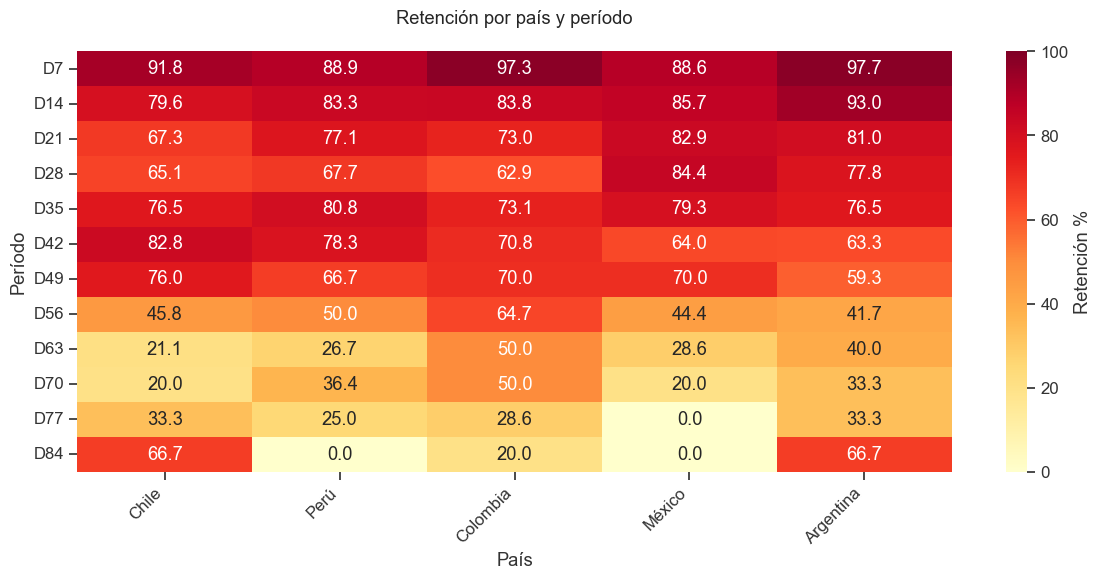

In [35]:
# Configurar el estilo
configurar_estilo_peliplat()
plt.figure(figsize=(12, 6))

# Preparar datos para el heatmap
# Convertimos los índices de períodos a números más legibles
retencion_paises.index = [f'D{periodo}' for periodo in [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]]

# Crear heatmap
sns.heatmap(retencion_paises,
            annot=True,  # Mostrar valores
            fmt='.1f',   # Formato de números con 1 decimal
            cmap='YlOrRd',  # Paleta de colores
            cbar_kws={'label': 'Retención %'},
            vmin=0,
            vmax=100)

# Configurar el gráfico
plt.title('Retención por país y período', pad=20)
plt.xlabel('País')
plt.ylabel('Período')

# Rotar etiquetas para mejor legibilidad
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajustar layout
plt.tight_layout()

# Guardar y mostrar
guardar_figura(plt.gcf(), "heatmap_retencion_pais.png")
plt.show()

### 5.3 Curvas de Retención por País

En esta sección se implementa una visualización comparativa de las curvas de retención para cada país:

1. Preparación del entorno visual:
   - Configuración del estilo corporativo
   - Definición de figura con dimensiones 12x7
   - Asignación de colores corporativos por país

2. Generación de curvas por país:
   - Iteración sobre países únicos en el dataset
   - Cálculo de serie temporal mediante `calcular_retencion_pais_serie`
   - Implementación de líneas con marcadores para cada país
   - Uso de paleta corporativa diferenciada

3. Elementos de formato:
   - Etiquetas de ejes con escala temporal y porcentual
   - Título principal y subtítulo explicativo
   - Cuadrícula de referencia con estilo suave
   - Leyenda posicionada a la derecha del gráfico

4. Exportación y visualización:
   - Ajuste automático de márgenes
   - Guardado como "curva_retencion_por_pais.png"
   - Presentación mediante `plt.show()`

Figura guardada en: ../reports/figures\curva_retencion_por_pais.png


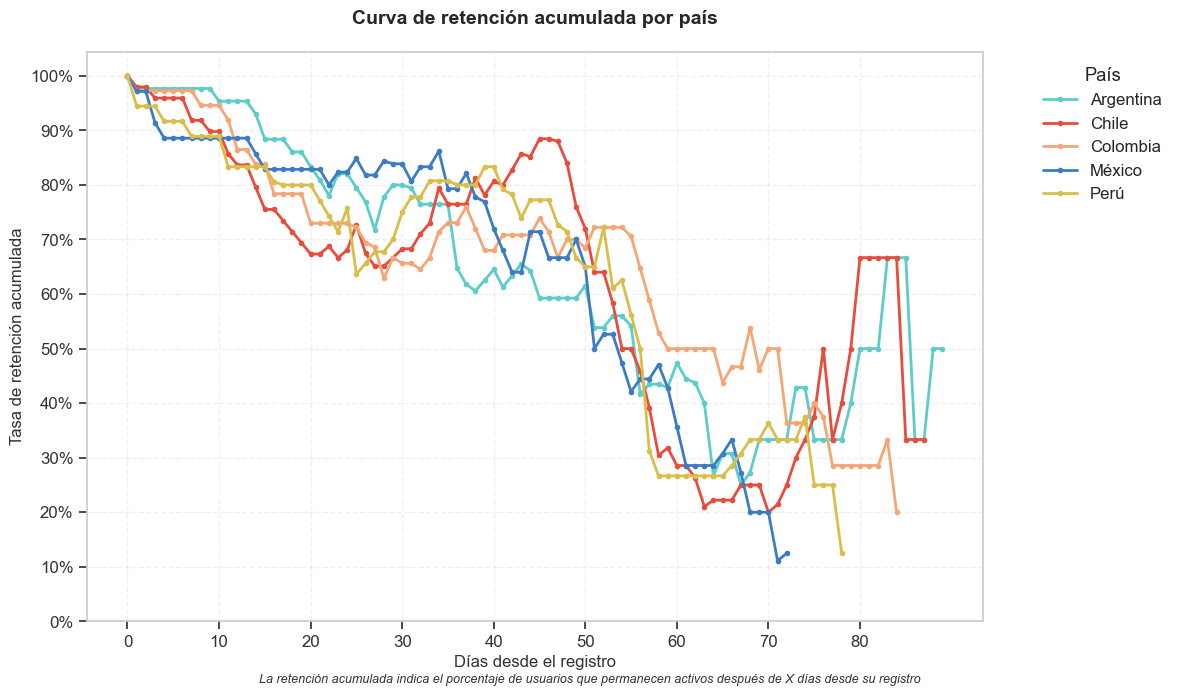

In [36]:
# Aplicar el estilo de Peliplat
configurar_estilo_peliplat()

# Crear el gráfico
fig = plt.figure(figsize=(12, 7))

# Definir colores para cada país
paises = sorted(users['country'].unique())
colores_pais = [COLORES_PELIPLAT['turquesa'], COLORES_PELIPLAT['accent'], 
                COLORES_PELIPLAT['secundario'], COLORES_PELIPLAT['azul'],
                COLORES_PELIPLAT['amarillo']]

# Plotear línea para cada país
for pais, color in zip(paises, colores_pais):
    usuarios_pais = users[users['country'] == pais]
    
    # Usar la función modularizada para el cálculo
    dias_validos, retencion_pais = calcular_retencion_pais_serie(usuarios_pais, dias)
    
    # Plotear línea solo para días con datos válidos
    plt.plot(dias_validos, retencion_pais, marker='o', markersize=3, linestyle='-', 
             color=color, linewidth=2, label=pais)

# Configurar etiquetas y título
plt.xlabel("Días desde el registro", fontsize=12)
plt.ylabel("Tasa de retención acumulada", fontsize=12)
plt.title("Curva de retención acumulada por país", fontsize=14, fontweight='bold', pad=20)

# Añadir subtítulo explicativo
plt.figtext(0.5, 0.01, 
            "La retención acumulada indica el porcentaje de usuarios que permanecen activos después de X días desde su registro", 
            ha='center', fontsize=9, style='italic', color=COLORES_PELIPLAT['texto'])

# Configurar cuadrícula y aspectos visuales
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(range(0, max_dias + 1, 10))
plt.yticks([x/10 for x in range(0, 11, 1)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# Añadir leyenda
plt.legend(title="País", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar márgenes
plt.tight_layout()

# Guardar la figura
guardar_figura(fig, nombre_archivo="curva_retencion_por_pais.png")

plt.show()